In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, mkdir
from os.path import isfile, join, exists
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

In [2]:
def show_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [3]:
def prepare_data(path, need_compress=False):
    if need_compress:
        compress_all_jpg_in_directory(path)
        path = path + "_compress"
        
    
    list_of_images = []
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for im in images:
        current_image = cv.imread(path + "/" + im)
        list_of_images.append(current_image)
    
    return list_of_images

В текущий момент мы хотим идентифицировать некий предмет (заметим, что для корретной работы предмет должен иметь ***прямоугольную форму***) на фотографии, затем заменять этот объект на другой предмет ***прямоугольной формы***.

Сразу заметим, что в текущей реализации задача является полностью ***unsupervised***, то есть нам не надо иметь обучающий датасет и тренироваться на нем. Мы будем только косвенно использовать элементы ***supersived learning*** для улучшения работы основного алгоритма, а именно классификаторы которые мы обучали ранее для детекции объекта на фотографии (мы можем получить вероятность присутствия объекта на фотографии) будем использовать с целью отсечения фотографий на который объект отсутсвует, только для этих целей (обучение классификатора) нам и понадобиться обучающая выборка.


Загрузим и посмотрим на нашу картинку, которая будет выступать в роли образца, который мы будем искать на фотографиях и заменять.

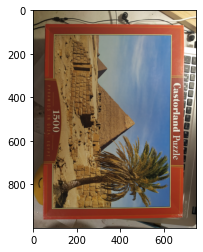

In [5]:
img = cv.imread('./dataset3/original_picture.png')
show_image(img)

Теперь загрузим и посмотрим на картинку, которой мы хотим заменять наш исходный объект.

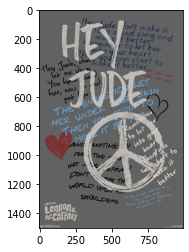

In [6]:
other = cv.imread('./poster4.jpg')
show_image(other)

Изменим размер до размеров картинов в нашем датасете.

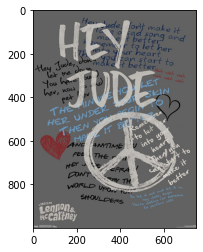

In [7]:
other = cv.resize(other, (img.shape[1], img.shape[0]))
show_image(other)

Опишем процесс замены предмета на изображении. С использованием дескриптора ORB и гомографий ищем границы объекта на изображении, и потом на это место проецируем новое изображение. Ниже приводим реализацию этой идеи.

In [136]:
def calc_ORB(img):
    sift = cv.ORB_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [137]:
def calc_matches(source, target_image, callable_descriptor):
    keypoints_first, descriptors_fisrt = callable_descriptor(source)
    keypoints_second, descriptors_second = callable_descriptor(target_image)
    
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_fisrt, descriptors_second)
    matches = sorted(matches, key=lambda x: x.distance)
    
    return keypoints_first, keypoints_second, matches

In [138]:
def calc_homography(source, target_image, callable_descriptor):
    keypoints_first, keypoints_second, matches = calc_matches(source, target_image, callable_descriptor)
    dst = np.array([keypoints_first[m.queryIdx].pt for m in matches]).astype(np.float32).reshape(-1, 1, 2)
    src = np.array([keypoints_second[m.trainIdx].pt for m in matches]).astype(np.float32).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src, dst, cv.RANSAC, 5.0)
    
    return M

In [139]:
def replace_image(source_rgb, target_image_rgb, new_image_rgb):
    source = cv.cvtColor(source_rgb, cv.COLOR_BGR2GRAY)
    target_image = cv.cvtColor(target_image_rgb, cv.COLOR_BGR2GRAY)
    new_image = cv.cvtColor(new_image_rgb, cv.COLOR_BGR2GRAY)
    
    M = calc_homography(source, target_image, calc_ORB)
    result = cv.warpPerspective(new_image_rgb, M, (new_image_rgb.shape[1], new_image_rgb.shape[0]))
    
    answer = np.zeros((1000, 750, 3))
    
    for i in range(answer.shape[0]):
        for j in range(answer.shape[1]):
            if np.array_equal(result[i][j], np.array([0, 0, 0])):
                answer[i][j] = source_rgb[i][j]
            else:
                answer[i][j] = result[i][j]
                
    return answer.clip(0, 255).astype(np.uint8)

Теперь обучим наш классификатор распозновать наш объект на изображениях.

Фотографии с нашим объектом:

In [153]:
picture_with_object = prepare_data('dataset1/dataset1_compress', False)
print('Count picture with object:', len(picture_with_object))

Count picture with object: 108


Фотографии без нашего объекта:

In [154]:
picture_without_object = prepare_data('dataset2/dataset2_compress', False)
picture_without_object.extend(prepare_data('dataset3/dataset3_compress', False))

print('Count picture without object', len(picture_without_object))

Count picture without object 210


Теперь соберем общий датасет.

In [155]:
data = picture_with_object + picture_without_object
y = np.hstack([np.ones(len(picture_with_object)), np.zeros(len(picture_without_object))])

Разобьем на train и test (test - 25%). Заметим, что данные у нас упорядоченные, но train_test_split делает случайное разделение выборки.

In [156]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

In [157]:
def fit_bag_of_words(data, callable_descriptor):
    all_descriptors = []
    for idx, current_image in enumerate(data):
        keypoints, descriptors = callable_descriptor(current_image)
        all_descriptors.extend(descriptors)
    
    # count of clusters
    k = 50
    kmeans = KMeans(n_clusters=k, verbose=False).fit(all_descriptors)
    
    return kmeans

In [158]:
def picture_to_vector(picture, k_means_pretrained, callable_descriptor, k_cluster=50):
    keypoints, descriptors = callable_descriptor(picture)
    histogram = np.zeros(k_cluster)
    kp_count = len(keypoints)
    
    for d in descriptors:
        idx = k_means_pretrained.predict([d])
        histogram[idx] += 1.0 / kp_count
        
    return histogram
    

Обучим bag of words на train выборке используя дескриптор ORB

In [160]:
k_means_train = fit_bag_of_words(x_train, calc_ORB)

Теперь сформируем датасеты в векторном представлении картинок, дальше будем работать с  Quadratic classifier. Используем дескриптор ORB.


In [161]:
x_train_vec = np.array([picture_to_vector(pic, k_means_train, calc_ORB) for pic in x_train])
x_test_vec = np.array([picture_to_vector(pic, k_means_train, calc_ORB) for pic in x_test])

In [164]:
quadratic_clf = QuadraticDiscriminantAnalysis()
quadratic_clf.fit(x_train_vec, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

Теперь мы сделаю обертку над нашей функцией, которая заменяет объект на изображении. Мы пробуем распознать наш объект на изображении с помощью обученого классификатора, и если вероятность, которую нам вернул классификатор выше некоторого порога то мы применяем наш алгоритм, иначе мы просто возвращаем исходную картинку.

In [185]:
def get_prob_predict(img, bag_of_words, pretrained_clf):
    vec_representation_of_picture = picture_to_vector(img, bag_of_words, calc_ORB)
    return (pretrained_clf.predict_proba([vec_representation_of_picture]))[0][0]

In [187]:
def replace_image_if(source_rgb, target_image_rgb, new_image_rgb, bag_of_words, pretrained_clf, threshold):
    prob = get_prob_predict(source_rgb, bag_of_words, pretrained_clf)
    if prob >= threshold:
        return replace_image(source_rgb, target_image_rgb, new_image_rgb)
    else:
        return source_rgb

Теперь посмотрим как это все работает. Выберем $n^2$ случайных картинок из датасета и применим наш алгортим.

Пусть $n = 4$

In [140]:
n = 4

In [192]:
all_images = prepare_data('dataset3/dataset3_compress', False)

In [193]:
test_images = np.random.choice(all_images, n ** 2, replace=False)

In [194]:
for i in range(len(test_images)):
    if test_images[i].shape[0] < test_images[i].shape[1]:
        test_images[i] = cv.rotate(test_images[i], cv.ROTATE_90_CLOCKWISE)

Посмотрим на эти картинки.

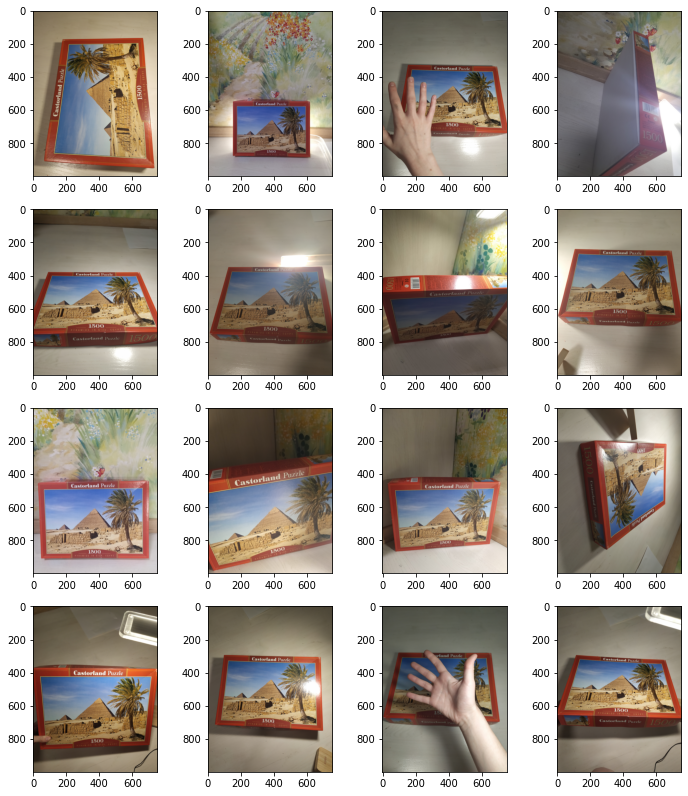

In [195]:
fig, axs = plt.subplots(n, n, figsize=(12, 14))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(cv.cvtColor(test_images[i * n + j], cv.COLOR_BGR2RGB))

Применим наш алгоритм.

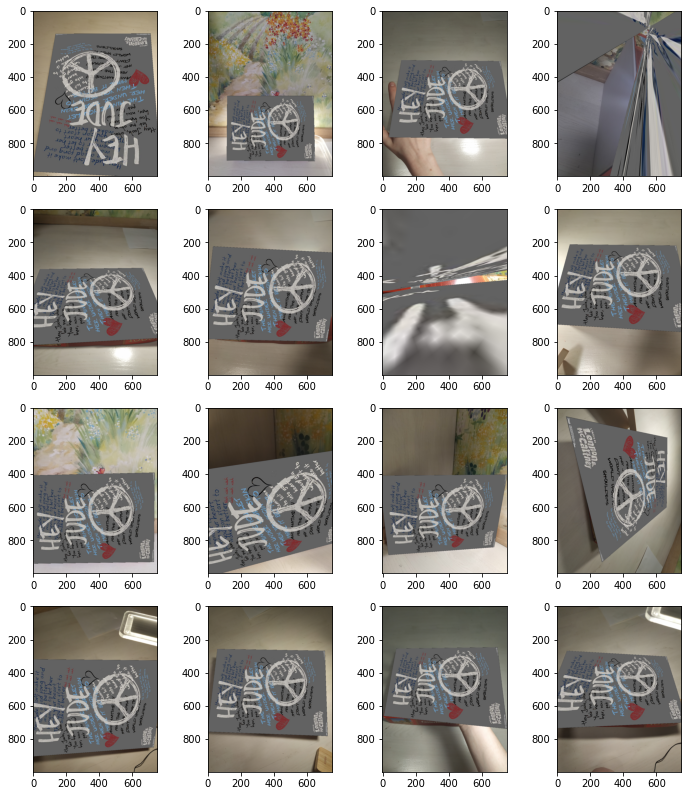

In [196]:
fig, axs = plt.subplots(n, n, figsize=(12, 14))
for i in range(n):
    for j in range(n):
        result = replace_image_if(test_images[i * n + j], img, other, k_means_train, quadratic_clf, 0.7)
        axs[i, j].imshow(cv.cvtColor(replace_image(test_images[i * n + j], img, other), cv.COLOR_BGR2RGB))

Как видим наш алгоритм отработал на всех картинках из тестового набора (причина этому может быть то, что мы обучались на обучающей выборке, а случайные изображения выбирает из выборки train+test, то есть можем встретиться с переобучением), наш классификатор пропустил все картинки с порогом 0.7. Далее вступает вход алгоритм детекций объекта с помощью гомографии, и как мы видим выше на 2 объект мы получили ужасный результат, который говорит о том, что мы не смогли адекватно обнаружить объект, все остальные примеры получились очень достойными.

***Выводы*** можно сделать следующие, что мы смогли получить полностью unsupervised алгоритм, который, например, можно легко использовать online. Наличие обучающей выборки нам дает шанс избегать ужасных результатов работы, в том случае если объект на изображении отсутствует или находится в необычном положении (необычном в смысле невозможности его детекции с помощью данного конкретного дескриптора и гомографии).

Качество (открытым остается вопрос, какую тут можно применить метрику качеста?) замены объекта на изображении в первую очередь от дескриптора (то есть от качества фич изображения) и алгоритма поиска гомографии (в нашем случае используется RANSAC, помним что он является рандомизированным). Скорость обработки зависит все от тех же факторов.